In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
import os
import pandas as pd
from PIL import Image
from scipy.spatial.distance import euclidean
current_directory = os.getcwd()
cifar_directory = os.path.join(current_directory,"../CIFAR-10")

### Loading the data 
The CIFAR10 data is saved as 5 batch files with flattened vectors rather than raw image data. The data is reassembled into a numpy array using helper functions and then converted to a pandas dataframe. The shape outputted is 50000 and 10000 for the train and test data set respectively but the data comes with no headers. Each row has 3072 columns because they flatten 32x32 pixel images with 3 channels (rgb) into 1d vectors.

In [2]:
# Helper function which use pickle to load the image data
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
    return batch

# Helper function which concatenate the data from the 5 files into one large file
def load_cifar10_data(data_dir):
    train_batches = []
    for i in range(1, 6):
        file_path = f"{data_dir}/data_batch_{i}"
        train_batches.append(load_cifar10_batch(file_path))

    test_batch = load_cifar10_batch(f"{data_dir}/test_batch")

    # Concatenate training batches to get the full training dataset
    train_data = np.concatenate([batch[b'data'] for batch in train_batches])
    train_labels = np.concatenate([batch[b'labels'] for batch in train_batches])

    # Extract test data and labels
    test_data = test_batch[b'data']
    test_labels = test_batch[b'labels']

    return train_data, train_labels, test_data, test_labels

label_mapping = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [3]:
# Load the data
train_data, train_labels, test_data, test_labels = load_cifar10_data(cifar_directory)

# Append the labels
columns = [f"pixel_{i+1}" for i in range(train_data.shape[1])]
train_df = pd.DataFrame(train_data, columns=columns)
train_df['label'] = train_labels

test_df = pd.DataFrame(test_data, columns=columns)
test_df['label'] = test_labels

In [4]:
# Metadata
print(f"Unique Labels: {len(set(train_labels))}, {list(label_mapping.values())}")
print("Train Dataset Shape:")
print(train_df.shape)
print("Test Dataset Shape:")
print(test_df.shape)
train_df.head()

Unique Labels: 10, ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Train Dataset Shape:
(50000, 3073)
Test Dataset Shape:
(10000, 3073)


,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,pixel_10,...,pixel_3064,pixel_3065,pixel_3066,pixel_3067,pixel_3068,pixel_3069,pixel_3070,pixel_3071,pixel_3072,label
0,59,43,50,68,98,119,139,145,149,149,...,58,65,59,46,57,104,140,84,72,6
1,154,126,105,102,125,155,172,180,142,111,...,42,67,101,122,133,136,139,142,144,9
2,255,253,253,253,253,253,253,253,253,253,...,83,80,69,66,72,79,83,83,84,9
3,28,37,38,42,44,40,40,24,32,43,...,39,59,42,44,48,38,28,37,46,4
4,170,168,177,183,181,177,181,184,189,189,...,88,85,82,83,79,78,82,78,80,1


### Class Balance
Occasionally, balancing the train data can prevention biased models when the data is extremely balanced towards a certain class. Here, the train and test data frequency is plotted. Interestingly, CIFAR10 has perfectly balanced classes. The conditions of the data collection should have been similar for all 3 datasets so this is an unexpected result. A possible solution would be to sample a subset of the test data with random selection.

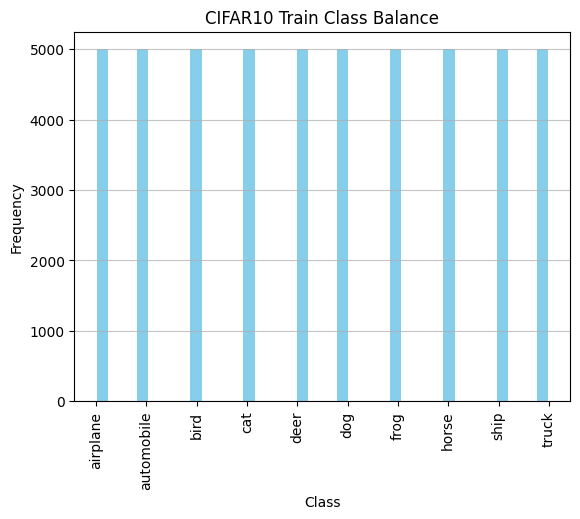

In [5]:
plt.hist(train_df['label'], bins='auto', color='skyblue', rwidth=0.85)

plt.xticks(list(label_mapping.keys()), list(label_mapping.values()), rotation='vertical')

plt.title('CIFAR10 Train Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

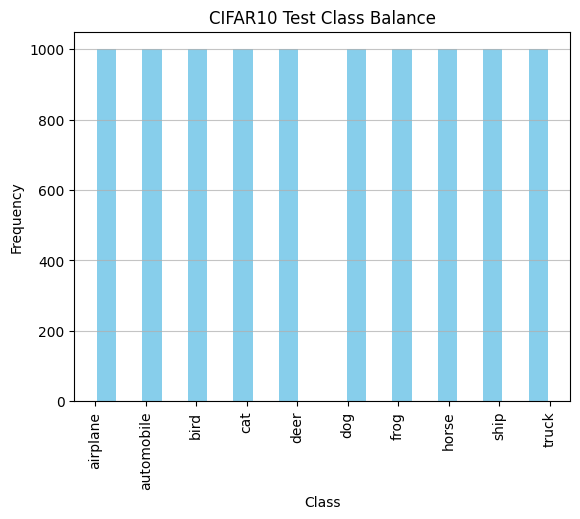

In [6]:
plt.hist(test_df['label'], bins='auto', color='skyblue', rwidth=0.85)

plt.xticks(list(label_mapping.keys()), list(label_mapping.values()), rotation='vertical')

plt.title('CIFAR10 Test Class Balance')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

plt.show()

### Transforming one-hot vectors to viewable image data
This dataset has a unique flattening procedure. Each third of the columns represents a color channel so the dataset is split into thirds. Then, each array of channels is stacked on each other so that at any row (image) and column (pixel), there are three values for an element representing the RGB values of a pixel. From there we unflatten each vector of pixels into a 32 x 32 matrix of pixels that can be interpreted by humans as an image. 

In [7]:
def convert_to_images(data_array):
    """
    Convert a single record into a viewable image. While we transform the entire dataset below, 
    this function will be useful if we do operations on one-hot vectors and 
    need to view the output as an human-interpretable image

    Parameters:
    - One-hot vector the first 1024 values represent the red channel of pixels, the second 1024 values represent the green channel of pixels, and the last 1024 values represent the blue channel of pixels

    Returns: 
    - a numpy array representing the image data

    Example:
        # Sample an element from image data to convert to PIL Image
        image = Image.fromarray(cifar_train_images.astype(np.uint8)[7], 'RGB')

        # # Display the image (optional)
        image.show()
        print(train_labels[7])
    """
    num_images = data_array.shape[0]
    image_size = 32

    # Split the array into three parts
    split_size = data_array.shape[1] // 3
    red_channel = data_array[:, :split_size]
    green_channel = data_array[:, split_size:2*split_size]
    blue_channel = data_array[:, 2*split_size:]
    print(f"Red Shape: {red_channel.shape}")
    print(f"Green Shape: {green_channel.shape}")
    print(f"Blue Shape: {blue_channel.shape}")

    # Stack the three parts horizontally
    stacked_channels = np.dstack([red_channel, green_channel, blue_channel])
    # print(stacked_channels.shape)

    # Reshape the stacked array into a 3D array
    images = stacked_channels.reshape((num_images, image_size, image_size, 3))

    return images


cifar_train_images = convert_to_images(np.array(train_data))
print(f"Unflattened Dataset Shape: {cifar_train_images.shape}")
# print(cifar_train_images)

Red Shape: (50000, 1024)
Green Shape: (50000, 1024)
Blue Shape: (50000, 1024)
Unflattened Dataset Shape: (50000, 32, 32, 3)


#### PCA

(50000, 3072)


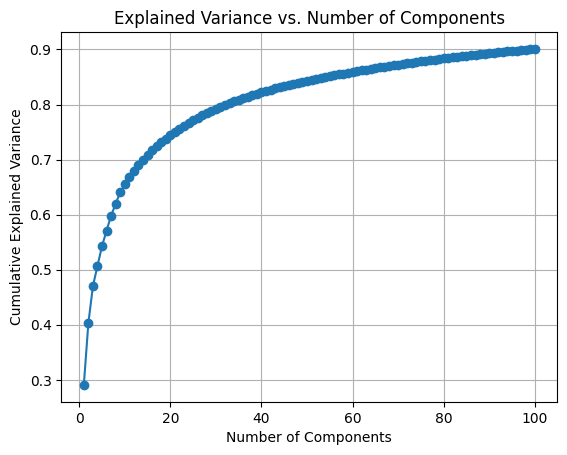

Kaiser's Rule for Necessary Number of Components: 22


In [8]:
from sklearn.decomposition import PCA

# Normalize the data (optional but recommended)
cifar_train_images_normalized = cifar_train_images / 255.0

# Choose the number of components for PCA
n_components = 100  # You can adjust this based on your requirements

# Reshape the data to 2D (number of samples, number of features)
reshaped_images = cifar_train_images_normalized.reshape((50000, -1))
print(reshaped_images.shape)
# Apply PCA
pca = PCA(n_components=n_components)
pca_result = pca.fit_transform(reshaped_images)

# Reconstruct the data after PCA
reconstructed_images_flattened = pca.inverse_transform(pca_result)

# Reshape the reconstructed data back to the original shape
reconstructed_images = reconstructed_images_flattened.reshape((50000, 32, 32, 3))

# Now 'reconstructed_images' contains the images after applying PCA

# You can also access the principal components and explained variance ratio
principal_components = pca.components_
explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plot the explained variance ratio
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.title('Explained Variance vs. Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

num_components = np.sum(pca.explained_variance_ > 1)

print(f"Kaiser's Rule for Necessary Number of Components: {num_components}")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


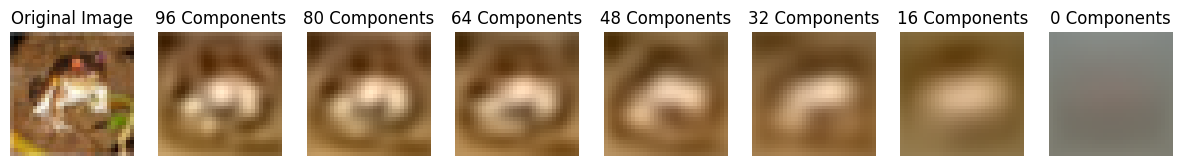

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a specific image from the dataset for visualization
image_index = 0

# Define a range of components to visualize
components_to_visualize = sorted(np.arange(0, n_components + 1, n_components / 6, dtype=int),reverse=True)

# Plot the original image
plt.figure(figsize=(15, 3))
plt.subplot(1, len(components_to_visualize) + 1, 1)
plt.imshow(cifar_train_images_normalized[image_index])
plt.title('Original Image')
plt.axis('off')

# Plot reconstructed images for different numbers of components
for i, n_components in enumerate(components_to_visualize):
    # Apply PCA with the specified number of components
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_images)

    # Reconstruct the image with the selected components
    reconstructed_image_flattened = pca.inverse_transform(pca_result[image_index])
    reconstructed_image = reconstructed_image_flattened.reshape((32, 32, 3))

    # Plot the reconstructed image
    plt.subplot(1, len(components_to_visualize) + 1, i + 2)
    plt.imshow(reconstructed_image)
    plt.title(f'{n_components} Components')
    plt.axis('off')

plt.show()


### Mean Image Vector (per label)
CIFAR10 only has 10 possible labels for their images so we can also compute a mean image for each label to get an idea of what the "average" image from each group will look like this. We do this by grouping the records by label, and then computing the mean of that group (column wise). 

Unlike MNIST, CIFAR10 images are a little more complex so the mean image is not as representative of the class.


Red Shape: (10, 1024)
Green Shape: (10, 1024)
Blue Shape: (10, 1024)


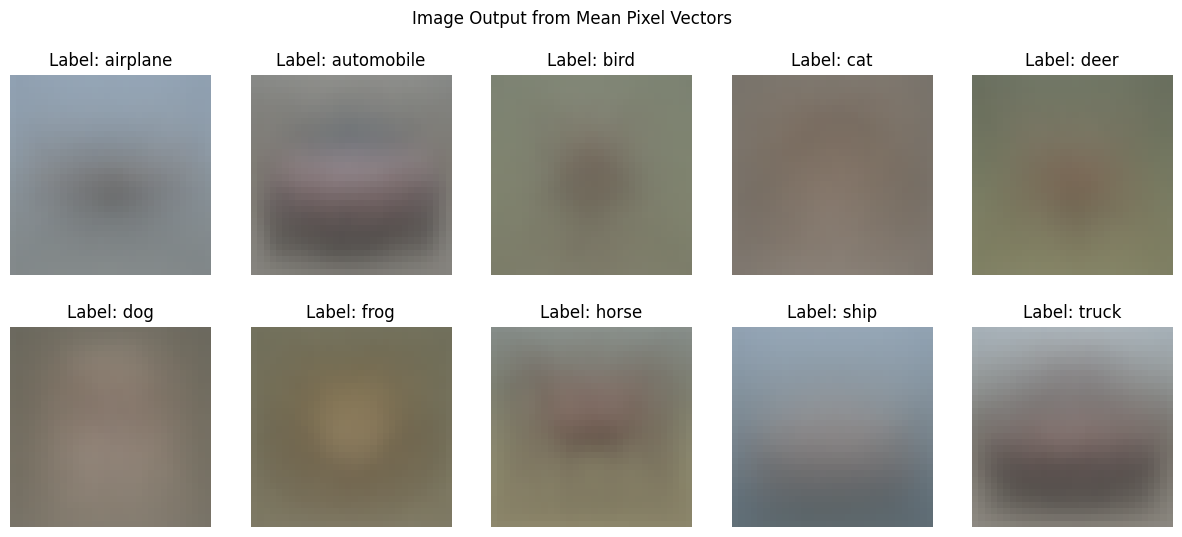

In [10]:
# Group by the first column (label) and compute the mean for each group
grouped_means = train_df.groupby('label').mean().astype(int)

# Reset index 
grouped_means.sort_values(by='label')
grouped_means.reset_index(inplace=True, drop=True)

# Convert one-hot vectors to images
cifar_images = convert_to_images(grouped_means.to_numpy())

# Display the images as a 3x3 matrix using matplotlib
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Image Output from Mean Pixel Vectors')

for i in range(2):
    for j in range(5):
        index = i * 5 + j
        feature_image = cifar_images[index]
        
        axes[i, j].imshow(feature_image)
        axes[i, j].set_title(f"Label: {label_mapping[index]}")
        axes[i, j].axis('off')


plt.show()

### Distance from the Mean Vector
To get an idea of how much images vary our mean vector we can calculate the euclidean distance of between each record and the mean record for that record's label. Summary statistics on our distances to will help measure how robust our dataset is.

In [11]:
# Calculate Euclidean distances between each vector and the mean vector
distances = {}

for index, row in train_df.iterrows():
    label = row['label']
    feature_data = row.iloc[:-1].to_numpy()
    mean_vector = grouped_means.iloc[label, :].to_numpy()

    distance = euclidean(feature_data, mean_vector)
    
    if label not in distances:
        distances[label] = []
    
    distances[label].append(distance)


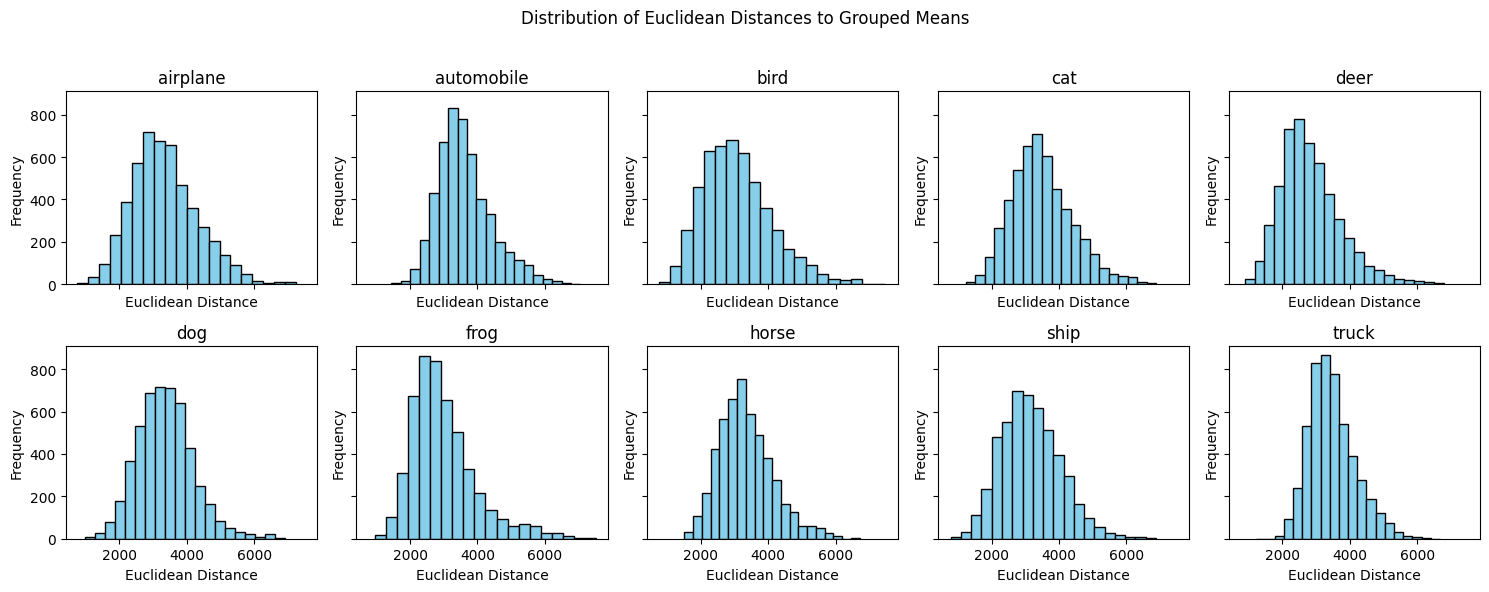

In [12]:
# Plotting Distances

# Create subplots for each label in increasing order
fig, axes = plt.subplots(2, 5, figsize=(15, 6), sharex=True, sharey=True)
fig.suptitle('Distribution of Euclidean Distances to Grouped Means')

# Sort labels in increasing order
sorted_labels = sorted(distances.keys())

# Plot histograms for each label
for i, label in enumerate(sorted_labels):
    dist_values = distances[label]
    ax = axes[i // 5, i % 5]
    ax.hist(dist_values, bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'{label_mapping[i]}')
    ax.set_xlabel('Euclidean Distance')
    ax.set_ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [13]:
# Printing Summary Statistics to an output file for each label 

summary_statistics = {}

for label, dist_values in distances.items():
    summary_statistics[label] = {
        'Mean': round(np.mean(dist_values), 2),
        'Standard Deviation': round(np.std(dist_values), 2),
        'Variance': round(np.var(dist_values), 2),
        '25th Percentile': round(np.percentile(dist_values, 25), 2),
        'Median': round(np.median(dist_values), 2),
        '75th Percentile': round(np.percentile(dist_values, 75), 2),
        'Min': round(np.min(dist_values), 2),
        'Max': round(np.max(dist_values), 2)
    }

# Define the output file path
output_file_path = 'cifar10_summary_statistics.txt'

# Open the output file and print summary statistics
with open(output_file_path, 'w') as output_file:
    for label in sorted(summary_statistics.keys()):
        stats = summary_statistics[label]
        output_file.write(f"Label {label_mapping[i]} Summary Statistics:\n")
        for stat_name, stat_value in stats.items():
            output_file.write(f"{stat_name}: {stat_value}\n")
        output_file.write("\n")

print(f"Summary statistics saved to: {output_file_path}")


Summary statistics saved to: cifar10_summary_statistics.txt


: 